<div class="alert alert-block alert-warning">
Submit this notebook via Moodle!
</div>

In [16]:
import pytest

import numpy as np
import matplotlib.pyplot as plt

from bandits import UCBAgent, ContextualClusteredBandit
from environments.base import State, Action
from environments.recsys import RecsysEnvironment

from utils import experiment_factory, run_multi_seeds
from utils import plot_reward_band

from typing import Any, Dict, List

In [17]:
# import functions from previous notebook
from ipynb.fs.full.N1_basic import ucb_select, ucb_update

# workaround if the ipynb import does not work for you:
#!jupyter nbconvert --to python N1_basic.ipynb
#from N1_basic import ucb_select, ucb_update

UCBAgent.select = ucb_select
UCBAgent.update = ucb_update

# **3. Contextual Bandits (4 Points)**

In this final part of the assignment, we will implement a simple **contextual bandit** that operates by running *N* independent bandits in parallel and selecting the one most suitable for the current **context** (i.e., user).  

To achieve this, we cluster user contexts (collected beforehand) into *N* distinct groups **a priori**.  
Each cluster represents a **state**, and at runtime, we determine a user’s cluster membership and select the corresponding agent.  
This allows us to leverage the intuition that **similar users exhibit similar preferences**.

Your task is to complete the wrapper class **`ContextualClusteredBandit`**, which encapsulates any of the previously implemented bandit algorithms.


## **Task 3.1. Implement the Contextual Bandit Wrapper (2 Points)**

The `ContextualClusteredBandit` class in `bandits.py` wraps around a base bandit algorithm and:

1. Samples user contexts from the environment and clusters them using **K-Means**.  
2. Creates **one independent non-contextual bandit agent per cluster** via `base_agent_factory`.

Your goal is to implement the `select` and `update` methods in the cells belowe so that they correctly **route calls** to the agent associated with the user’s current cluster. The sections that require your input are marked with `# TODO: YOUR CODE HERE`.

- Use `_fast_predict(s.context)` to determine the user’s cluster membership.  
  This function returns the **index of the nearest cluster center** to the 1D context vector `x` using precomputed centers:

  $$
  \arg\min_i \|x - C_i\|^2
  $$


### **Tests**

To verify your implementation during development, run the test cell below.  
If your implementation is correct, all tests should pass without errors.

In [18]:
# use `help` this to show all avalable attributes; uncomment the line below...
# help(ContextualClusteredBandit)

In [19]:


def select(self, s: State) -> int:
    """
    Select an arm for the given user. Use _fast_predict and s.context to find the user's cluster.
    """
    if s.context is None:
        raise ValueError("User must be provided to select().")
    cluster = self._fast_predict(s.context)
    self._last_cluster = cluster
    return int(self.agents[cluster].select(s))


In [20]:


def update(self, arm_id: int, reward: float, s: State) -> None:
    """
    Update the agent that handled the selection for the given user.
    """
    if s.context is None:
        raise ValueError("User must be provided to select().")
    cluster = self._fast_predict(s.context)
    self._last_cluster = cluster
    self.agents[cluster].update(arm_id, reward, s)


In [21]:
ContextualClusteredBandit.select = select
ContextualClusteredBandit.update = update
print("Clustered Contextual Bandits"); print("All tests passed!" if pytest.main(["--disable-warnings", "-q", "tests/test_contextual.py"]) == 0 else "Some tests failed.")

Clustered Contextual Bandits
..                                                                       [100%]
2 passed in 0.04s
All tests passed!


## **Task 3.2: Find an Appropriate Number of States (1 Point)**

Before running the contextual agent, we need to determine a suitable number of **user clusters** (or “states”) for the contextual bandit model.

A partial implementation is provided below.  
Your task is to:

- Define a suitable range for the number of clusters (`K_RANGE`).  
- Use scikit-learn’s **K-Means** implementation to cluster the user contexts.  
- Evaluate each clustering configuration using an appropriate metric (e.g., **Silhouette Score**).  
- Store the computed scores in the list `cluster_scores` for visualization.

The section that requires your input is marked with `# TODO: YOUR CODE HERE`.

Then store the value of `K` with the highest score in the variable `N_CLUSTERS` below.

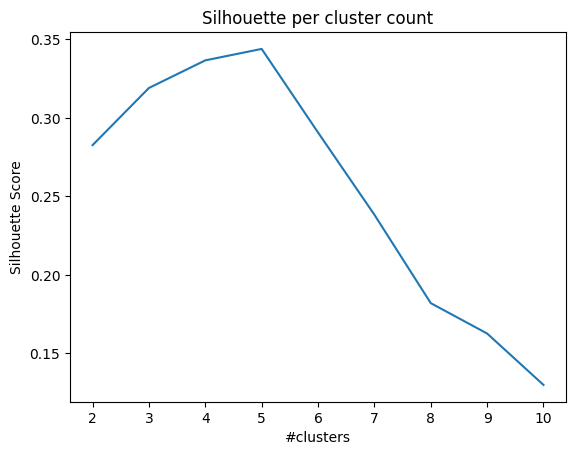

In [22]:

# you might want to use these here :)
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

N_USERS, RNG = 10_000, np.random.RandomState(19241)
env = RecsysEnvironment(RNG)
X, X_test = env.sample_contexts(samples=N_USERS), env.sample_contexts(samples=N_USERS)

# try a small range of cluster counts
K_RANGE = list(range(2, 11))
cluster_scores = []

for k in K_RANGE:
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=RNG.randint(1e6))
    labels = kmeans.fit_predict(X)
    score = silhouette_score(X, labels)
    cluster_scores.append(score)

# --- plot ---
plt.plot(K_RANGE, cluster_scores)
plt.xlabel("#clusters")
plt.ylabel("Silhouette Score")
plt.title("Silhouette per cluster count")
plt.show()


In [23]:


# pick K with best silhouette score
N_CLUSTERS = int(K_RANGE[int(np.argmax(cluster_scores))])


In [24]:
assert type(N_CLUSTERS) is int

### **Task 3.3: Compare UCB and Contextual UCB**

Now, conduct a small experiment comparing the performance of **UCB** in both **contextual** and **non-contextual** modes. Can you observe any benefits when using the contextual bandit setup? You can modify the provided code as needed to adjust parameters, random seeds, or visualization styles.

<Axes: title={'center': 'Reward (mean line with Q25–Q75 band) — 200 seeds'}, xlabel='time (minutes)', ylabel='Reward'>

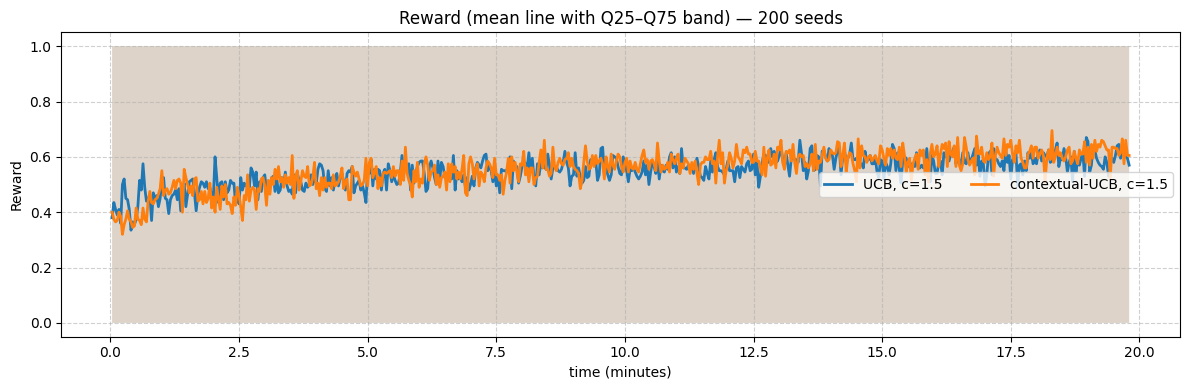

In [25]:
# -----------------------------------------
# reduce, if you can't afford the compute
# -----------------------------------------
SEEDS = np.arange(200)
N_STEPS = int(30*60*0.33) # run simulation of arpund 20 minutes

# -----------------------------------------
# initialize experiments
# -----------------------------------------
groups = {}

c=1.5
groups[f"UCB, c={c}"] = experiment_factory(
    lambda rng: UCBAgent(c=c),
    lambda rng: RecsysEnvironment(rng=rng)
)

groups[f"contextual-UCB, c={c}"] = experiment_factory(
    lambda rng: UCBAgent(c=c),
    lambda rng: RecsysEnvironment(rng=rng),
    contextual=True,
    n_clusters=N_CLUSTERS
)

# -----------------------------------------
# run experiments
# -----------------------------------------
group_stats: Dict[str, Dict[str, Any]] = {}
for name, builder in groups.items():
    group_stats[name] = run_multi_seeds(builder, SEEDS, n_steps=N_STEPS)

# -----------------------------------------
# Plot: mean line + min–max band
# -----------------------------------------
plot_reward_band(group_stats, users_per_minute=30)

**Question 3.3. (1 Point)** In the long-run, is the contextual bandit better then the non-contextual one? Store your answer in the variable provided below.

In [26]:

CONTEXTUAL_IS_BETTER = True


In [27]:
assert type(CONTEXTUAL_IS_BETTER) is bool